<a href="https://colab.research.google.com/github/yejinhwang6101/electricity-power/blob/main/sfcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

실험 환경 라이브러리 설치 및 데이터 확인

In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import sys
import tqdm as tq
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
df = pd.read_csv("C:/Users/USER/PycharmProjects/pythonProject/4. LSTM+Autoencoder/power.csv", low_memory=False)

# 데이터 정제 과정
for col in ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # 숫자로 변환할 수 없는 값은 NaN으로 설정

print("="*50)
print("First Five Rows ","\n")
print(df.head(2),"\n")

print("="*50)
print("Information About Dataset","\n")
print(df.info(),"\n")

print("="*50)
print("Describe the Dataset ","\n")
print(df.describe(),"\n")

print("="*50)
print("Null Values t ","\n")
print(df.isnull().sum(),"\n")

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/USER/PycharmProjects/pythonProject/4. LSTM+Autoencoder/power.csv'

In [ ]:
# Extract all Data Like Year MOnth Day Time etc
dataset = df
# 날짜 및 시간 관련 변수 생성
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time
df['Hour'] = df['Time'].apply(lambda x: x.hour)
df['Week'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# 요일별 및 시간대별 통계 계산
grouped = df.groupby(['Week', 'Hour'])
mean_day = grouped['Global_active_power'].mean().reset_index()
std_day = grouped['Global_active_power'].std().reset_index()
skew_day = grouped['Global_active_power'].apply(lambda x: 3 * (x.mean() - x.median()) / x.std()).reset_index()

# 데이터 프레임에 추가
df = df.merge(mean_day, on=['Week', 'Hour'], suffixes=('', '_mean'))
df = df.merge(std_day, on=['Week', 'Hour'], suffixes=('', '_std'))
df = df.merge(skew_day, on=['Week', 'Hour'], suffixes=('', '_skew'))

dataset.head(1)

NameError: name 'df' is not defined

In [ ]:
# 'Global_active_power' 컬럼에서 이상치 식별
Q1 = df['Global_active_power'].quantile(0.25)
Q3 = df['Global_active_power'].quantile(0.75)
IQR = Q3 - Q1

# 이상치의 범위를 정의 (일반적으로 Q1 - 1.5*IQR 이하 또는 Q3 + 1.5*IQR 이상)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치를 포함하는 행을 필터링
outliers = df[(df['Global_active_power'] < lower_bound) | (df['Global_active_power'] > upper_bound)]

# 이상치 제거
df_cleaned = df[~((df['Global_active_power'] < lower_bound) | (df['Global_active_power'] > upper_bound))]

print(f"Original Data Size: {df.shape[0]}")
print(f"Cleaned Data Size: {df_cleaned.shape[0]}")
print(f"Number of Outliers Removed: {df.shape[0] - df_cleaned.shape[0]}")# 'Global_active_power' 컬럼에서 이상치 식별
Q1 = df['Global_active_power'].quantile(0.25)
Q3 = df['Global_active_power'].quantile(0.75)
IQR = Q3 - Q1

# 이상치의 범위를 정의 (일반적으로 Q1 - 1.5*IQR 이하 또는 Q3 + 1.5*IQR 이상)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치를 포함하는 행을 필터링
outliers = df[(df['Global_active_power'] < lower_bound) | (df['Global_active_power'] > upper_bound)]

# 이상치 제거
df_cleaned = df[~((df['Global_active_power'] < lower_bound) | (df['Global_active_power'] > upper_bound))]

print(f"Original Data Size: {df.shape[0]}")
print(f"Cleaned Data Size: {df_cleaned.shape[0]}")
print(f"Number of Outliers Removed: {df.shape[0] - df_cleaned.shape[0]}")

NameError: name 'df' is not defined

데이터 셋 그래프 확인

In [ ]:
# 그래프 설정
fig = plt.figure(figsize=(15, 40))

# 2007년부터 2010년까지 각 연도의 월별 서브플롯 생성
for year in range(2007, 2011):
    for month in range(1, 13):
        if year == 2010 and month > 11:
            break
        ax = plt.subplot(16, 5, (year - 2007) * 12 + month)
        monthly_data = df[(df['Year'] == year) & (df['Month'] == month)]['Global_active_power'].dropna()
        mean = monthly_data.mean()
        std = monthly_data.std()

        # std가 NaN인 경우 0으로 처리
        mean = round(mean, 3) if not np.isnan(mean) else 0
        std = round(std, 3) if not np.isnan(std) else 0
        skew = 0 if std == 0 else round((3 * (mean - np.median(monthly_data)) / std), 3)

        # 왜도에 따른 히스토그램 색상 설정
        color = 'gray'
        if skew >= 1.5:
            color = 'red'
        elif skew <= -1.5:
            color = 'blue'

        # 히스토그램 그리기
        plt.hist(monthly_data, alpha=0.7, bins=50, color=color)
        plt.title(f'{year} - Month {month}')
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('')
        plt.ylabel('')
        plt.text(0.35, 0.9, f'mean : {mean}', ha='left', va='center', transform=ax.transAxes)
        plt.text(0.35, 0.8, f'std : {std}', ha='left', va='center', transform=ax.transAxes)
        plt.text(0.35, 0.7, f'skew : {skew}', ha='left', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

NameError: name 'df' is not defined

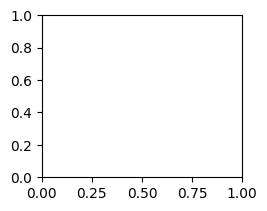

In [ ]:
fig = plt.figure(figsize=(15, 40))

# 2007년부터 2010년까지 각 연도의 월별 서브플롯 생성
for year in range(2007, 2011):
    for month in range(1, 13):
        if year == 2010 and month > 11:
            break
        ax = plt.subplot(16, 5, (year - 2007) * 12 + month)
        monthly_data = df[(df['Year'] == year) & (df['Month'] == month)]['Global_active_power'].dropna()

        # 역수 변환 적용 (0을 피하기 위해 1을 더함)
        monthly_data_reciprocal = 1 / (monthly_data + 1)
        mean = monthly_data_reciprocal.mean()
        std = monthly_data_reciprocal.std()

        # std가 NaN인 경우 0으로 처리
        mean = round(mean, 3) if not np.isnan(mean) else 0
        std = round(std, 3) if not np.isnan(std) else 0
        skew = 0 if std == 0 else round((3 * (mean - np.median(monthly_data_reciprocal)) / std), 3)

        # 왜도에 따른 히스토그램 색상 설정
        color = 'gray'
        if skew >= 1.5:
            color = 'red'
        elif skew <= -1.5:
            color = 'blue'

        # 히스토그램 그리기
        plt.hist(monthly_data_reciprocal, alpha=0.7, bins=50, color=color)
        plt.title(f'{year} - Month {month}')
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('')
        plt.ylabel('')
        plt.text(0.5, 0.9, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()


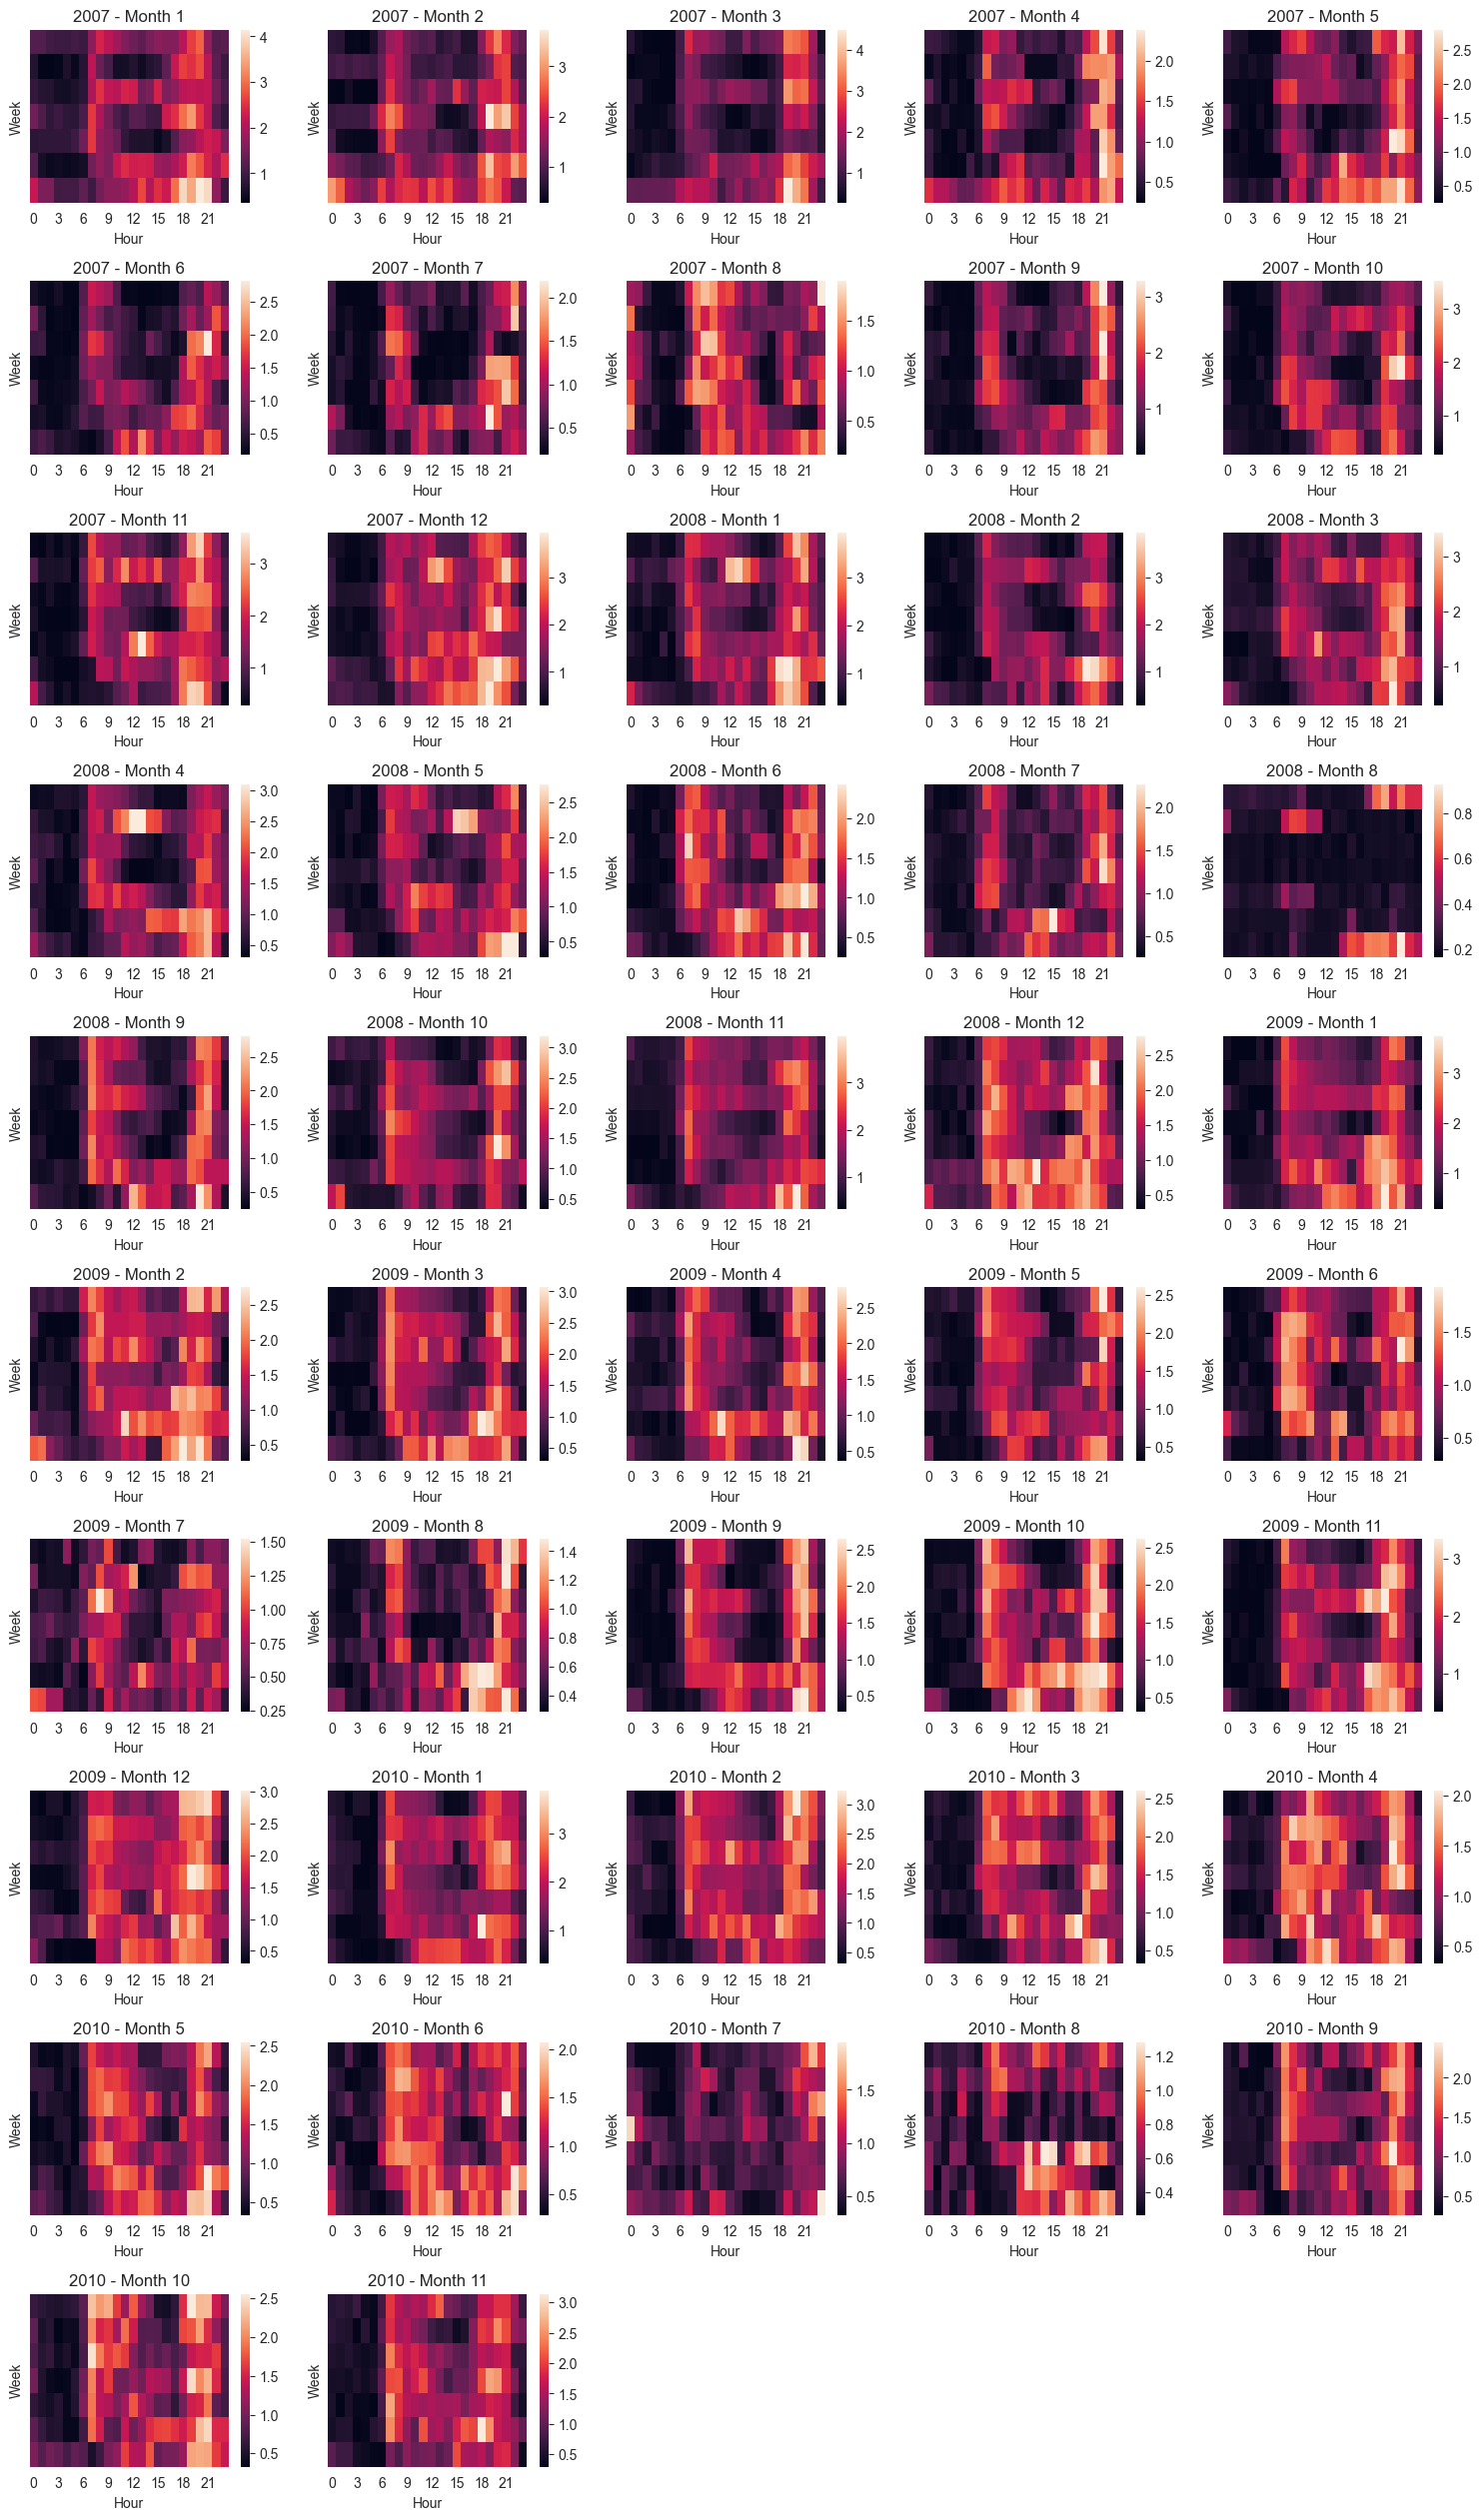

In [ ]:
fig = plt.figure(figsize=(15, 40))

# 2007년부터 2010년까지 각 연도의 월별 히트맵 생성
for year in range(2007, 2011):
    for month in range(1, 13):
        if year == 2010 and month > 11:  # 2010년은 11월까지만 데이터가 있다고 가정
            break
        ax = plt.subplot(16, 5, (year - 2007) * 12 + month)
        monthly_df = df[(df['Year'] == year) & (df['Month'] == month)]
        heatmap_data = monthly_df.groupby(['Week', 'Hour'])['Global_active_power'].mean().unstack()

        sns.heatmap(heatmap_data, ax=ax)
        plt.title(f'{year} - Month {month}')
        plt.xlabel('Hour')
        plt.ylabel('Week')
        plt.yticks([])

plt.tight_layout()
plt.show()

결측치 확인 및 전처리

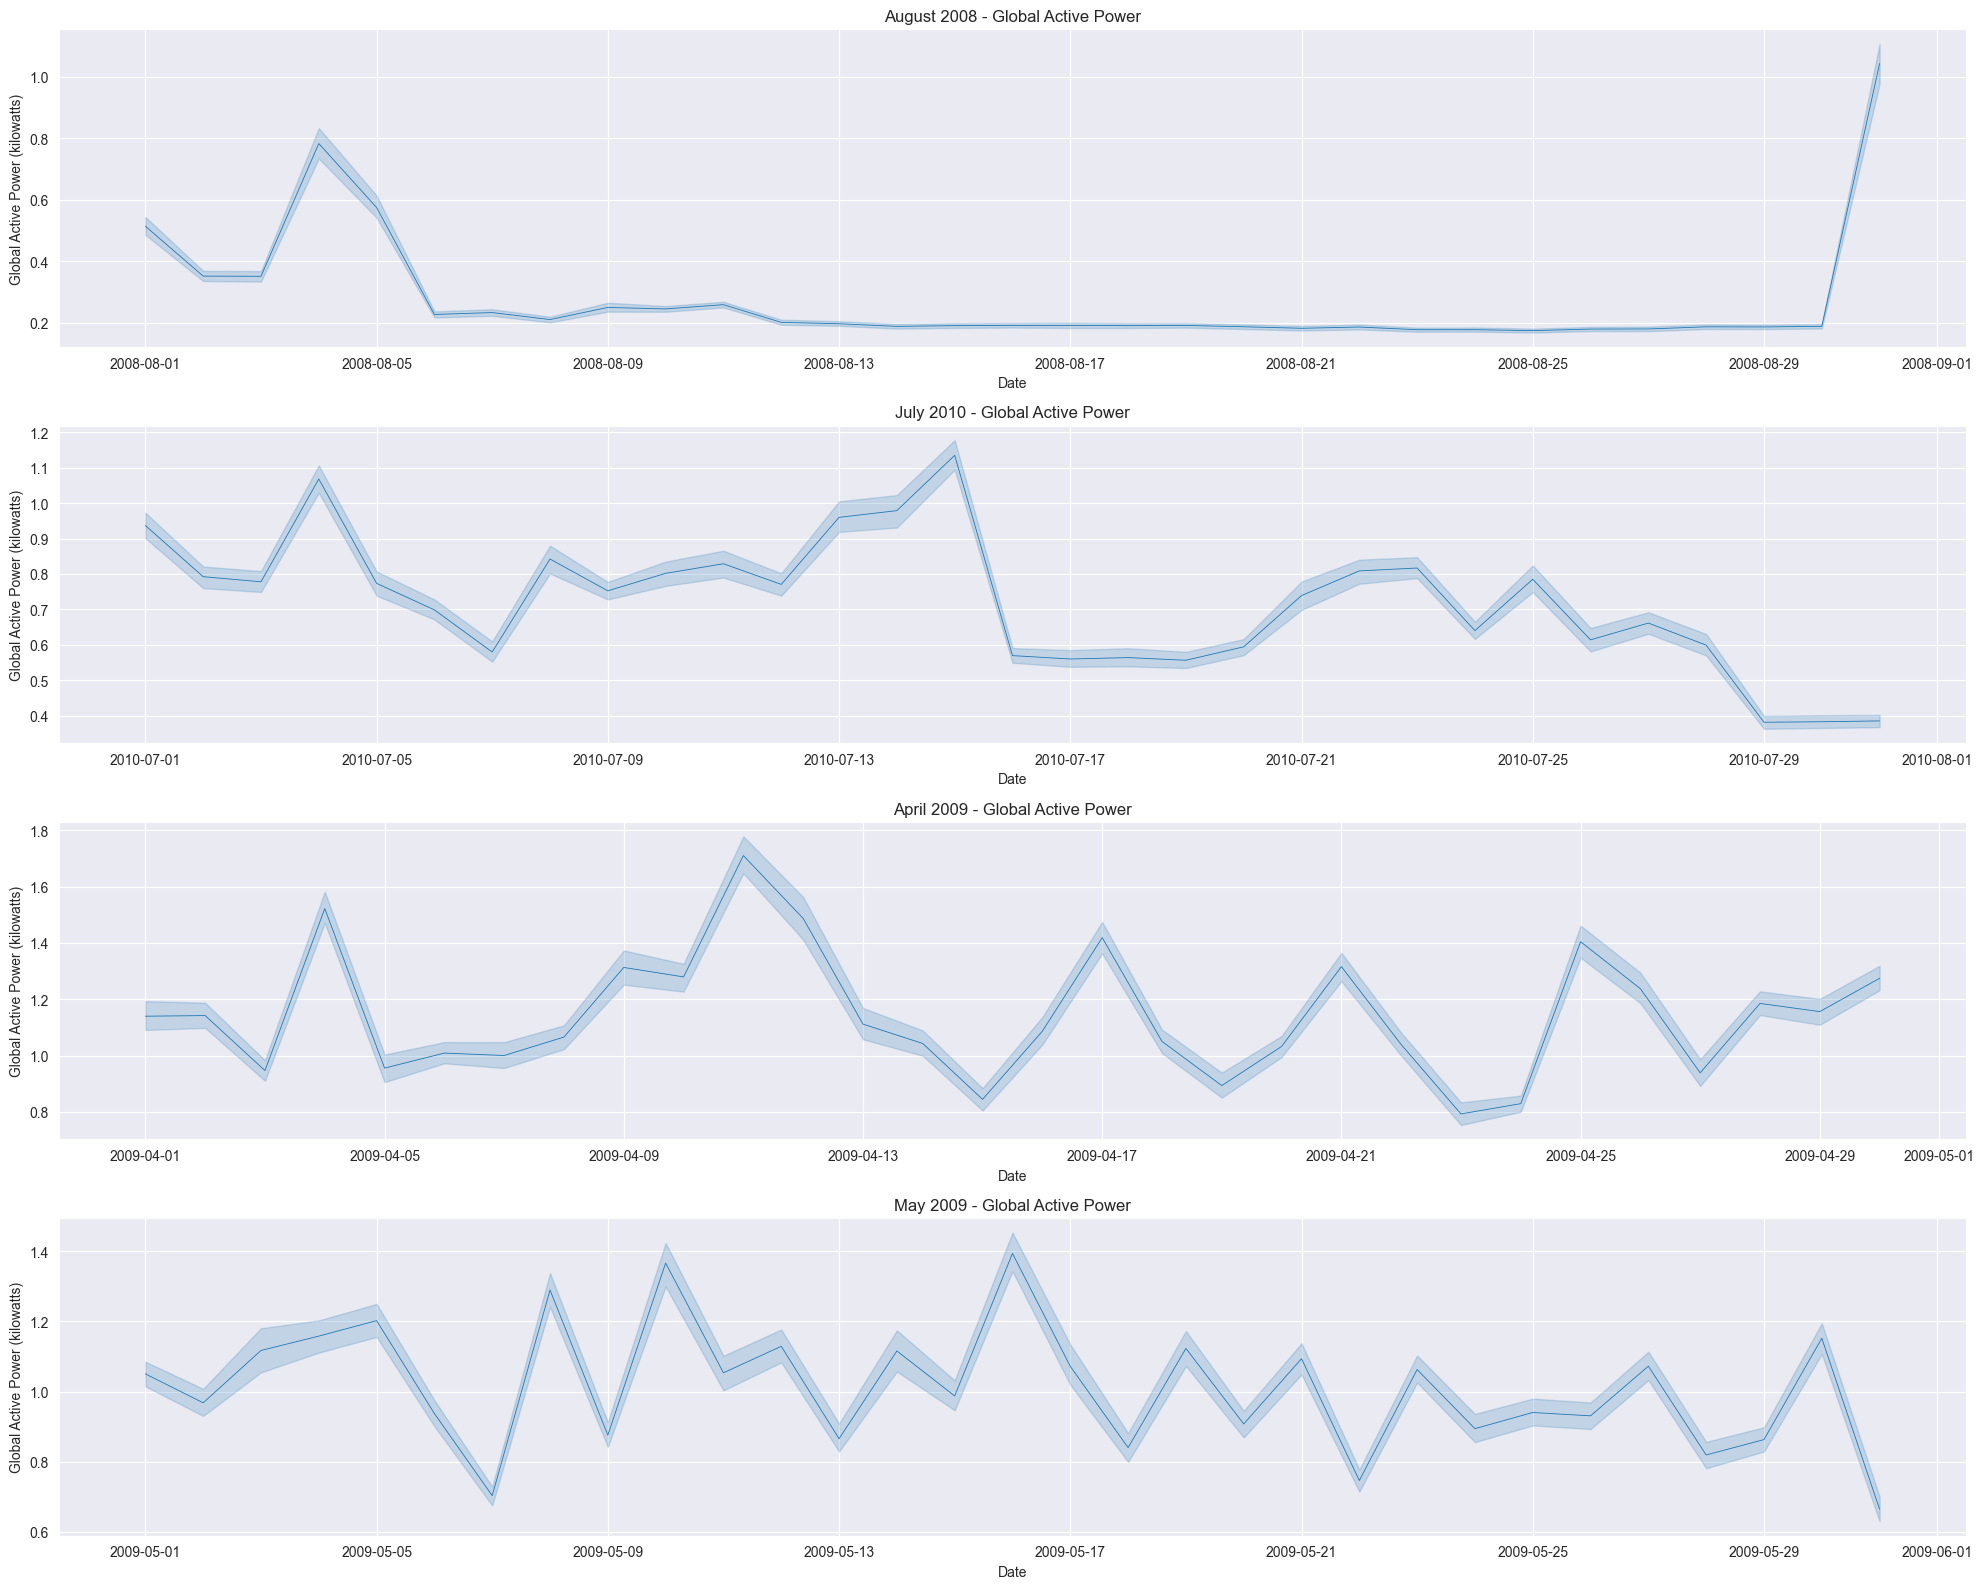

In [ ]:
# 필요한 연도와 월 데이터 필터링
aug_2008 = df[(df['Year'] == 2008) & (df['Month'] == 8)]
jul_2010 = df[(df['Year'] == 2010) & (df['Month'] == 7)]
apr_2009 = df[(df['Year'] == 2009) & (df['Month'] == 4)]
may_2009 = df[(df['Year'] == 2009) & (df['Month'] == 5)]

# 그래프 설정
fig = plt.figure(figsize=(20, 16))

# 2008년 8월 데이터 시각화
plt.subplot(411)
sns.lineplot(data=aug_2008, x='Date', y='Global_active_power', linewidth=0.6)
plt.title('August 2008 - Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')

# 2010년 7월 데이터 시각화
plt.subplot(412)
sns.lineplot(data=jul_2010, x='Date', y='Global_active_power', linewidth=0.6)
plt.title('July 2010 - Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')

# 2009년 4월 데이터 시각화
plt.subplot(413)
sns.lineplot(data=apr_2009, x='Date', y='Global_active_power', linewidth=0.6)
plt.title('April 2009 - Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')

# 2009년 5월 데이터 시각화
plt.subplot(414)
sns.lineplot(data=may_2009, x='Date', y='Global_active_power', linewidth=0.6)
plt.title('May 2009 - Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')

plt.tight_layout()
plt.show()

In [ ]:
# 2008년 8월, 2010년 7월 데이터 삭제
df = df[~((df['Date'].dt.year == 2008) & (df['Date'].dt.month == 8))]
df = df[~((df['Date'].dt.year == 2010) & (df['Date'].dt.month == 7))]
# 결과 확인
print(df.head())

        Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0 2006-12-16  17:24:00                4.216                  0.418   234.84   
1 2006-12-16  17:25:00                5.360                  0.436   233.63   
2 2006-12-16  17:26:00                5.374                  0.498   233.29   
3 2006-12-16  17:27:00                5.388                  0.502   233.74   
4 2006-12-16  17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  Hour  \
0              18.4             0.0             1.0            17.0    17   
1              23.0             0.0             1.0            16.0    17   
2              23.0             0.0             2.0            17.0    17   
3              23.0             0.0             1.0            17.0    17   
4              15.8             0.0             1.0            17.0    17   

   Week  Month  Year  Global_active_power_mean  Global_active_

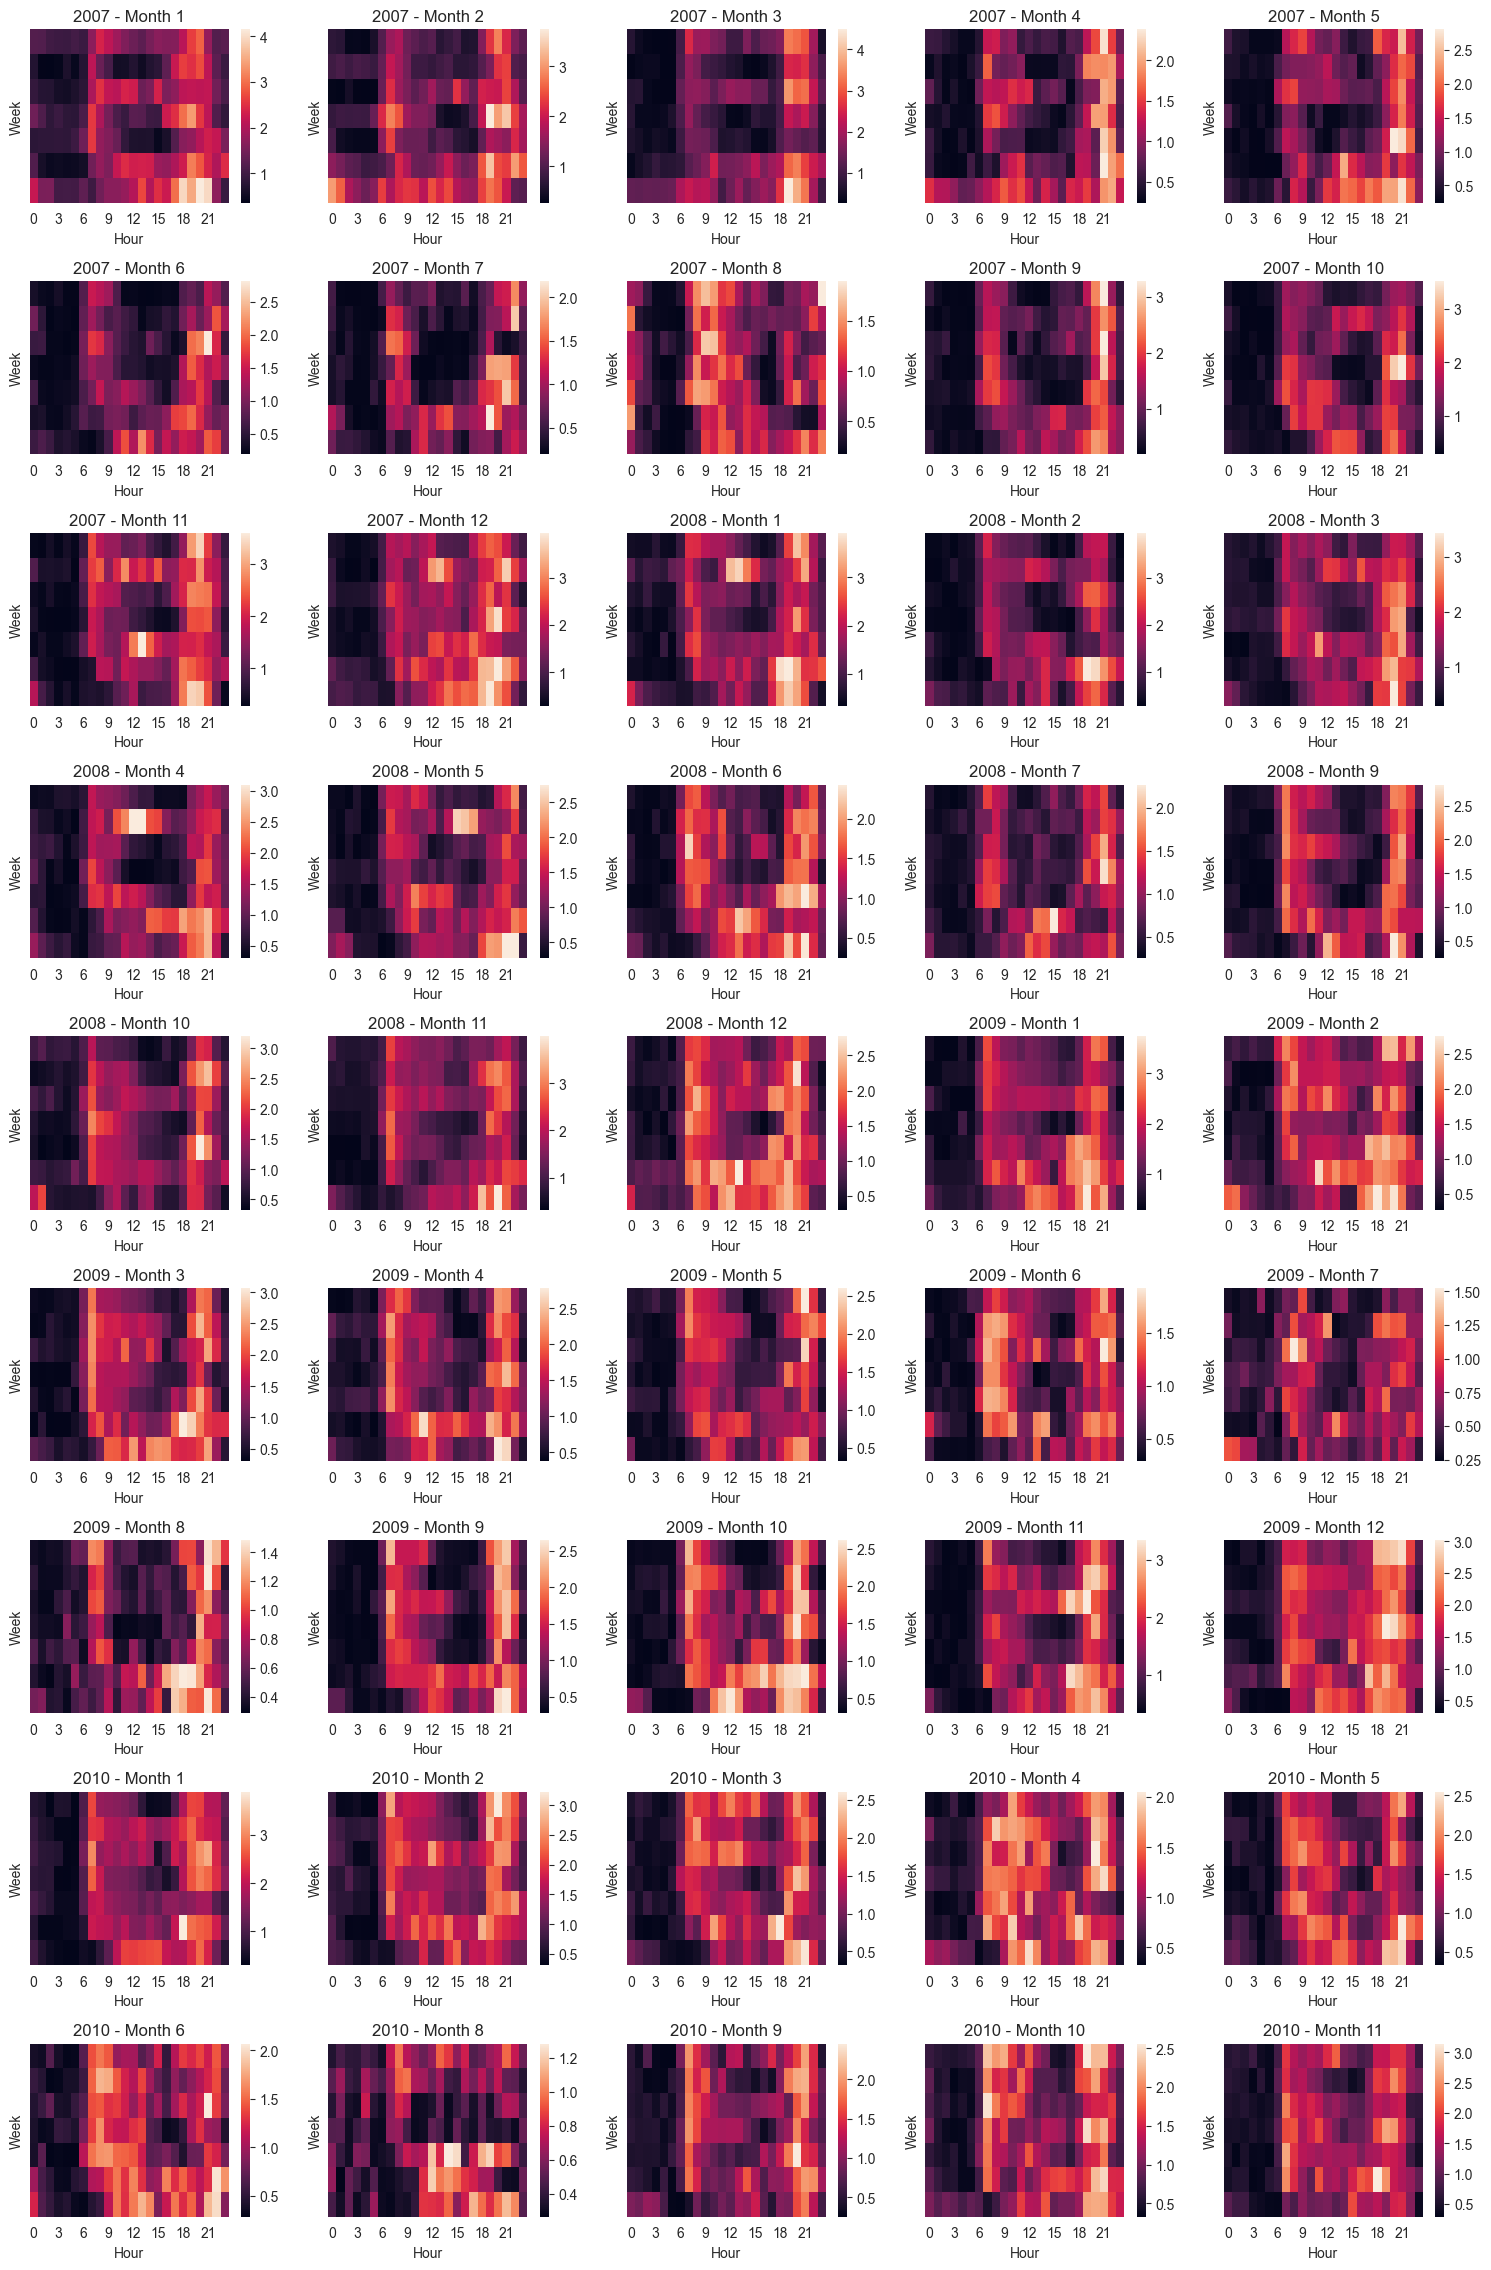

In [ ]:
fig = plt.figure(figsize=(15, 40))

# 2007년부터 2010년까지 각 연도의 월별 히트맵 생성
subplot_num = 1  # 서브플롯 번호 초기화
for year in range(2007, 2011):
    for month in range(1, 13):
        # 2010년은 11월까지만 데이터가 있다고 가정
        if year == 2010 and month > 11:
            break

        # 2008년 8월과 2010년 7월 데이터를 건너뛰기
        if (year == 2008 and month == 8) or (year == 2010 and month == 7):
            continue

        ax = plt.subplot(16, 5, subplot_num)
        monthly_df = df[(df['Year'] == year) & (df['Month'] == month)]
        heatmap_data = monthly_df.groupby(['Week', 'Hour'])['Global_active_power'].mean().unstack()

        sns.heatmap(heatmap_data, ax=ax)
        plt.title(f'{year} - Month {month}')
        plt.xlabel('Hour')
        plt.ylabel('Week')
        plt.yticks([])

        subplot_num += 1  # 서브플롯 번호 증가

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.dates as mdates


# 날짜 범위 설정 (2007년 1월부터 2010년 11월까지)
start_date = '2007-01-01'
end_date = '2010-11-30'
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
df = df[(df['DateTime'] >= start_date) & (df['DateTime'] <= end_date)]

# 마지막 1달을 검증 세트로 설정
last_month = df['DateTime'].max() - pd.DateOffset(months=1)
train_df = df[df['DateTime'] <= last_month]
valid_df = df[df['DateTime'] > last_month]

# 전처리된 데이터 저장
train_df.to_csv('power_train.csv', index=False)
valid_df.to_csv('power_valid.csv', index=False)

# 데이터 shape 출력
print('Train data shape:', train_df.shape)
print('Validation data shape:', valid_df.shape)

Train data shape: (1919343, 17)
Validation data shape: (44640, 17)


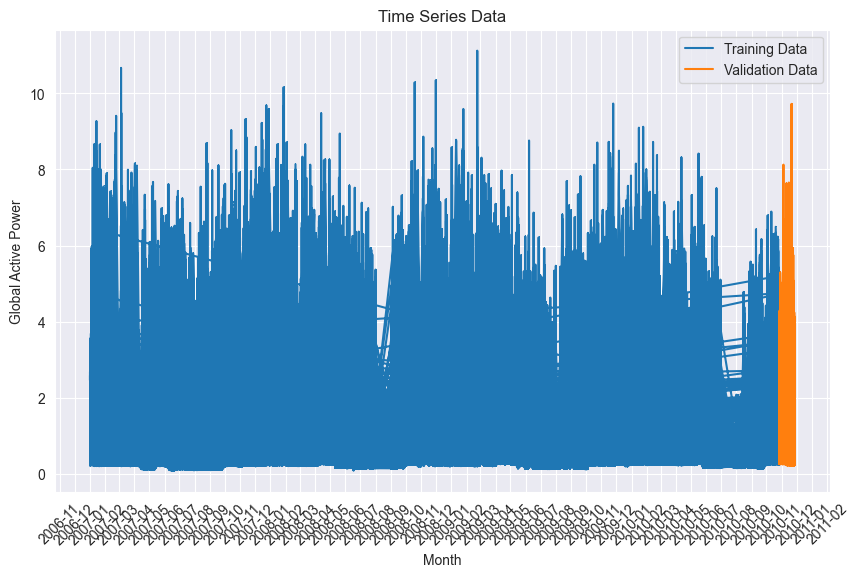

In [ ]:
# 타겟 변수 설정
y_train = train_df['Global_active_power']
y_valid = valid_df['Global_active_power']

# 특성 데이터 설정 (Date와 Time 컬럼 제거)
x_train = train_df.drop(['Global_active_power', 'DateTime', 'Date', 'Time'], axis=1)
x_valid = valid_df.drop(['Global_active_power', 'DateTime', 'Date', 'Time'], axis=1)

# 시계열 데이터 시각화
def plot_series(train_index, valid_index, y_train, y_valid, markers):
    plt.figure(figsize=(10, 6))
    plt.plot(train_index, y_train, marker=markers[0], label='Training Data')
    plt.plot(valid_index, y_valid, marker=markers[1], label='Validation Data')
    plt.title('Time Series Data')
    plt.xlabel('Month')
    plt.ylabel('Global Active Power')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

plot_series(train_df['DateTime'], valid_df['DateTime'], y_train, y_valid, markers=[',' , ','])

In [ ]:
# Define SMAPE loss function
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

In [ ]:
print("실제값이 100일 때 50으로 underestimate할 때의 SMAPE : {}".format(SMAPE(100, 50)))
print("실제값이 100일 때 150으로 overestimate할 때의 SMAPE : {}".format(SMAPE(100, 150)))

실제값이 100일 때 50으로 underestimate할 때의 SMAPE : 33.33333333333333
실제값이 100일 때 150으로 overestimate할 때의 SMAPE : 20.0


In [ ]:
#### alpha를 argument로 받는 함수로 실제 objective function을 wrapping하여 alpha값을 쉽게 조정할 수 있도록 작성했습니다.
# custom objective function for forcing model not to underestimate
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

In [ ]:
# 하이퍼파라미터 로드
xgb_params = pd.read_csv('C:/Users/USER/PycharmProjects/pythonProject/4. LSTM+Autoencoder/parameters/hyperparameter_xgb.csv')

# 데이터셋에서 NaN 및 무한대 값을 제거하는 함수
def remove_nan_and_inf(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    return df

# y_train, y_valid, x_train, x_valid에서 NaN 및 무한대 값을 제거
y_train_cleaned = remove_nan_and_inf(y_train.copy())
y_valid_cleaned = remove_nan_and_inf(y_valid.copy())
x_train_cleaned = remove_nan_and_inf(x_train.copy())
x_valid_cleaned = remove_nan_and_inf(x_valid.copy())

# XGBoost 모델 생성 및 훈련
xgb_reg = XGBRegressor(
    n_estimators=10000,
    eta=xgb_params.iloc[47,1],
    min_child_weight=xgb_params.iloc[47,2],
    max_depth=int(xgb_params.iloc[47,3]),
    colsample_bytree=xgb_params.iloc[47,4],
    subsample=xgb_params.iloc[47,5],
    seed=0,
    early_stopping_rounds=300  # 여기에 추가
)

xgb_reg.fit(x_train_cleaned, y_train_cleaned, eval_set=[(x_train_cleaned, y_train_cleaned), (x_valid_cleaned, y_valid_cleaned)],
            verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=300,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=6, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10000,
             n_jobs=None, num_parallel_tree=None, ...)

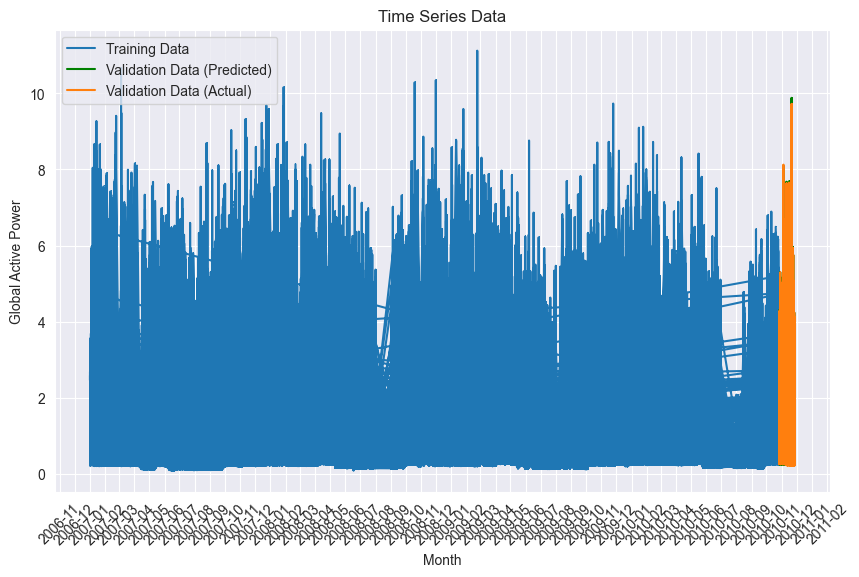

best iterations: 9999
SMAPE : 2.5176500337085606


In [ ]:
# 예측 수행
pred = xgb_reg.predict(x_valid)
pred_series = pd.Series(pred, index=valid_df['DateTime'])

# 시계열 데이터 시각화
def plot_series(train_index, valid_index, y_train, y_valid, y_pred, markers):
    plt.figure(figsize=(10, 6))
    plt.plot(train_index, y_train, marker=markers[0], label='Training Data')
    plt.plot(valid_index, y_pred, marker=markers[2], color='green', label='Validation Data (Predicted)')
    plt.plot(valid_index, y_valid, marker=markers[1], label='Validation Data (Actual)')
    plt.title('Time Series Data')
    plt.xlabel('Month')
    plt.ylabel('Global Active Power')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

plot_series(train_df['DateTime'], valid_df['DateTime'], y_train, y_valid, pred_series, markers=[',' , ',', ','])

# SMAPE 함수 정의
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# 결과 출력
print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(y_valid_cleaned, pred)))